In [11]:
from detectors_utils import filter_ripple_band
from detectors import Karlsson_ripple_detector, Kay_ripple_detector
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [ ]:
from eight_arm.set_input import days_8arm,days_andrea,rats_vlad,rats_andrea,Data_folder,analysis_folder,sample_rate_whl,sample_rate_data,wind_size_r,overlap_r,cell_types

In [ ]:
# days = [
#     ['280523']
# ]
# rats = ['jc293']
# maze_type = ['vlad']

# days = [
#    ['20220920']
# ]
# rats = ['JC283']
# maze_type = ['andrea']

days = days_8arm+days_andrea
rats =  rats_vlad + rats_andrea
maze_type=[]
for i in range(len(rats_vlad)):
    maze_type.append('vlad')
for i in range(len(rats_andrea)):
    maze_type.append('andrea')

plot=False

NUMBER_OF_CHANNELS = 24
SAMPLING_FREQUENCY = 1250 # Hz
LFP_ERROR_THRESHOLD = 5000 # in mV

In [ ]:
for rat_i in range(len(rats)):
    rat=rats[rat_i]
    
    for day in days[rat_i]:
        
        path = Data_folder + rat + "-" + day + "/"
        analysis_dir = analysis_folder + rat + "-" + day + "/"
        
        if not os.path.isdir(analysis_dir):
            os.makedirs(analysis_dir)
        # load maze param and des for a day
        files = os.listdir(path)
        item=rat + "-" + day + '_training2.whl'
        length_train=1
        if item in files:
            length_train=length_train+1

        for training_num in range(0,length_train+1):
            for state in ['awake','sleep']:

                if training_num == 0 and state == 'awake':
                    continue

                if state == 'awake':
                    name_sleep = 'training' + str(training_num)
                else:
                    if training_num == 0:
                        name_sleep = 'presleep'  
                    elif training_num == 1:
                        name_sleep = 'intersleep' 
                    else:
                        name_sleep = 'postsleep'

                lfp_path = path + rat + "-" + day + '_' + name_sleep + '.eeg'
                
                lfps_values = []
                with open(lfp_path, 'r') as file:
                    for line in file:
                        values = [int(val) for val in line.split()]
                        lfps_values.extend(values)
                file.close()
                # Convert the list to a NumPy array
                lfps_flat = np.array(lfps_values, dtype=np.int64)
                lfps= lfps_flat.reshape(NUMBER_OF_CHANNELS, int(len(lfps_flat)/NUMBER_OF_CHANNELS))
                
                lfps[lfps > LFP_ERROR_THRESHOLD] = LFP_ERROR_THRESHOLD  
                lfps[lfps < -LFP_ERROR_THRESHOLD] = -LFP_ERROR_THRESHOLD
                ### anything above threshold mV is regarded as being an error and is set to threshold mV
                ## alternatively set this to the previous index value but need to do this serially as if 4900 5000 5100 5200 then one shot gives 4900 4900 5000 5100 or find the last
                ## entry which was under 5000 and set all the values above 5000 to that value until the value comes under the threshold again
                
                if state = 'awake':
                    speed = np.loadtxt(analysis_dir + rat + "_" + day + '_training' + str(training_num) + '.speed')
                else:
                    speed = np.squeeze( np.zeros( (1, len(filtered_lfps[0,:]))   )) ## for sleep state 
                    ## can add sleep state detection and then you can have 0 for sleep and actual for not sleep
                
                filtered_lfps = filter_ripple_band(lfps)
                ## can also use Karlsson ripple detector
                ripple_times = Kay_ripple_detector(
                                                                np.arange(len(filtered_lfps[0,:])), #time  change this to actual
                                                                filtered_lfps[:,:].T, 
                                                                speed, 
                                                                SAMPLING_FREQUENCY,
                                                                speed_threshold=4.0,
                                                                minimum_duration=18.75,  ## in 1250hz   0.015 in seconds
                                                                zscore_threshold=3.0,
                                                                smoothing_sigma=0.004, ## assumes time is in seconds   Amount to smooth the time series over time. 
                                                                                       #                The default is given assuming time is in units of seconds.
                                                                close_ripple_threshold=0.0
                                                            )
                display(ripple_times)

                ripple_times.to_csv(analysis_dir + rat + "-" + day + '_' + name_sleep +  '_' + 'SWR.csv')

# END OF THE FINAL CODE. BELOW CODE THAT WAS TESTED BEGINS

In [8]:
NUMBER_OF_CHANNELS = 24
SAMPLING_FREQUENCY = 1250 # Hz
LFP_ERROR_THRESHOLD = 5000 # in mV
# File path
file_path = '/home/shaurya/Downloads/jc290-230223tetro_postsleep.eeg'
lfps_values = []
with open(file_path, 'r') as file:
    for line in file:
        values = [int(val) for val in line.split()]
        lfps_values.extend(values)

# Convert the list to a NumPy array
lfps_flat = np.array(lfps_values, dtype=np.int64)
lfps= lfps_flat.reshape(NUMBER_OF_CHANNELS, int(len(lfps_flat)/NUMBER_OF_CHANNELS))
lfps[lfps > 5000] = 5000
lfps.shape
filtered_lfps = filter_ripple_band(lfps)
filtered_lfps

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


array([[   0,  -25,  -28, ...,  -56,  -35,   -1],
       [   0,   -2,   35, ...,  -95,  -71,   -2],
       [  -3, -177, -214, ...,  -45,  -35,   -3],
       ...,
       [   0,    8,    5, ...,   51,   49,    0],
       [   0,  -45,  -34, ...,   -8,   -8,    1],
       [   0,    4,    0, ...,   27,   31,   -1]])

In [10]:
Kay_ripple_times = Kay_ripple_detector(
    np.arange(len(filtered_lfps[0,:])), 
    filtered_lfps[:,:].T, 
   np.squeeze( 0* np.ones( (1, len(filtered_lfps[0,:]))   )) , #speed
    SAMPLING_FREQUENCY,
    minimum_duration=18,  ## in 1250hz   0.015 in seconds
    zscore_threshold=3.0,
    smoothing_sigma=0.004,
)
display(Kay_ripple_times)

,start_time,end_time,peak_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,,
1,1219944,1220061,1220032,117,6.444145,6.941989,16.815383,0.019643,0.0,0.0,0.0,0.0,0.0,0.0
2,1220122,1220216,1220168,94,8.000756,3.853824,23.074603,0.006736,0.0,0.0,0.0,0.0,0.0,0.0
3,1223890,1224040,1223940,150,3.304852,1.595696,9.479185,0.003047,0.0,0.0,0.0,0.0,0.0,0.0
4,1269937,1270063,1269997,126,8.339907,5.763240,28.837747,0.011467,0.0,0.0,0.0,0.0,0.0,0.0
5,1270128,1270217,1270187,89,4.047449,2.891212,12.324868,0.015283,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,8774513,8774557,8774535,44,3.855213,3.315872,8.762076,0.018268,0.0,0.0,0.0,0.0,0.0,0.0
759,8864760,8864888,8864822,128,1.636711,0.426643,9.278635,0.025892,0.0,0.0,0.0,0.0,0.0,0.0
760,8874469,8874573,8874541,104,5.166256,1.337621,18.782162,0.008031,0.0,0.0,0.0,0.0,0.0,0.0


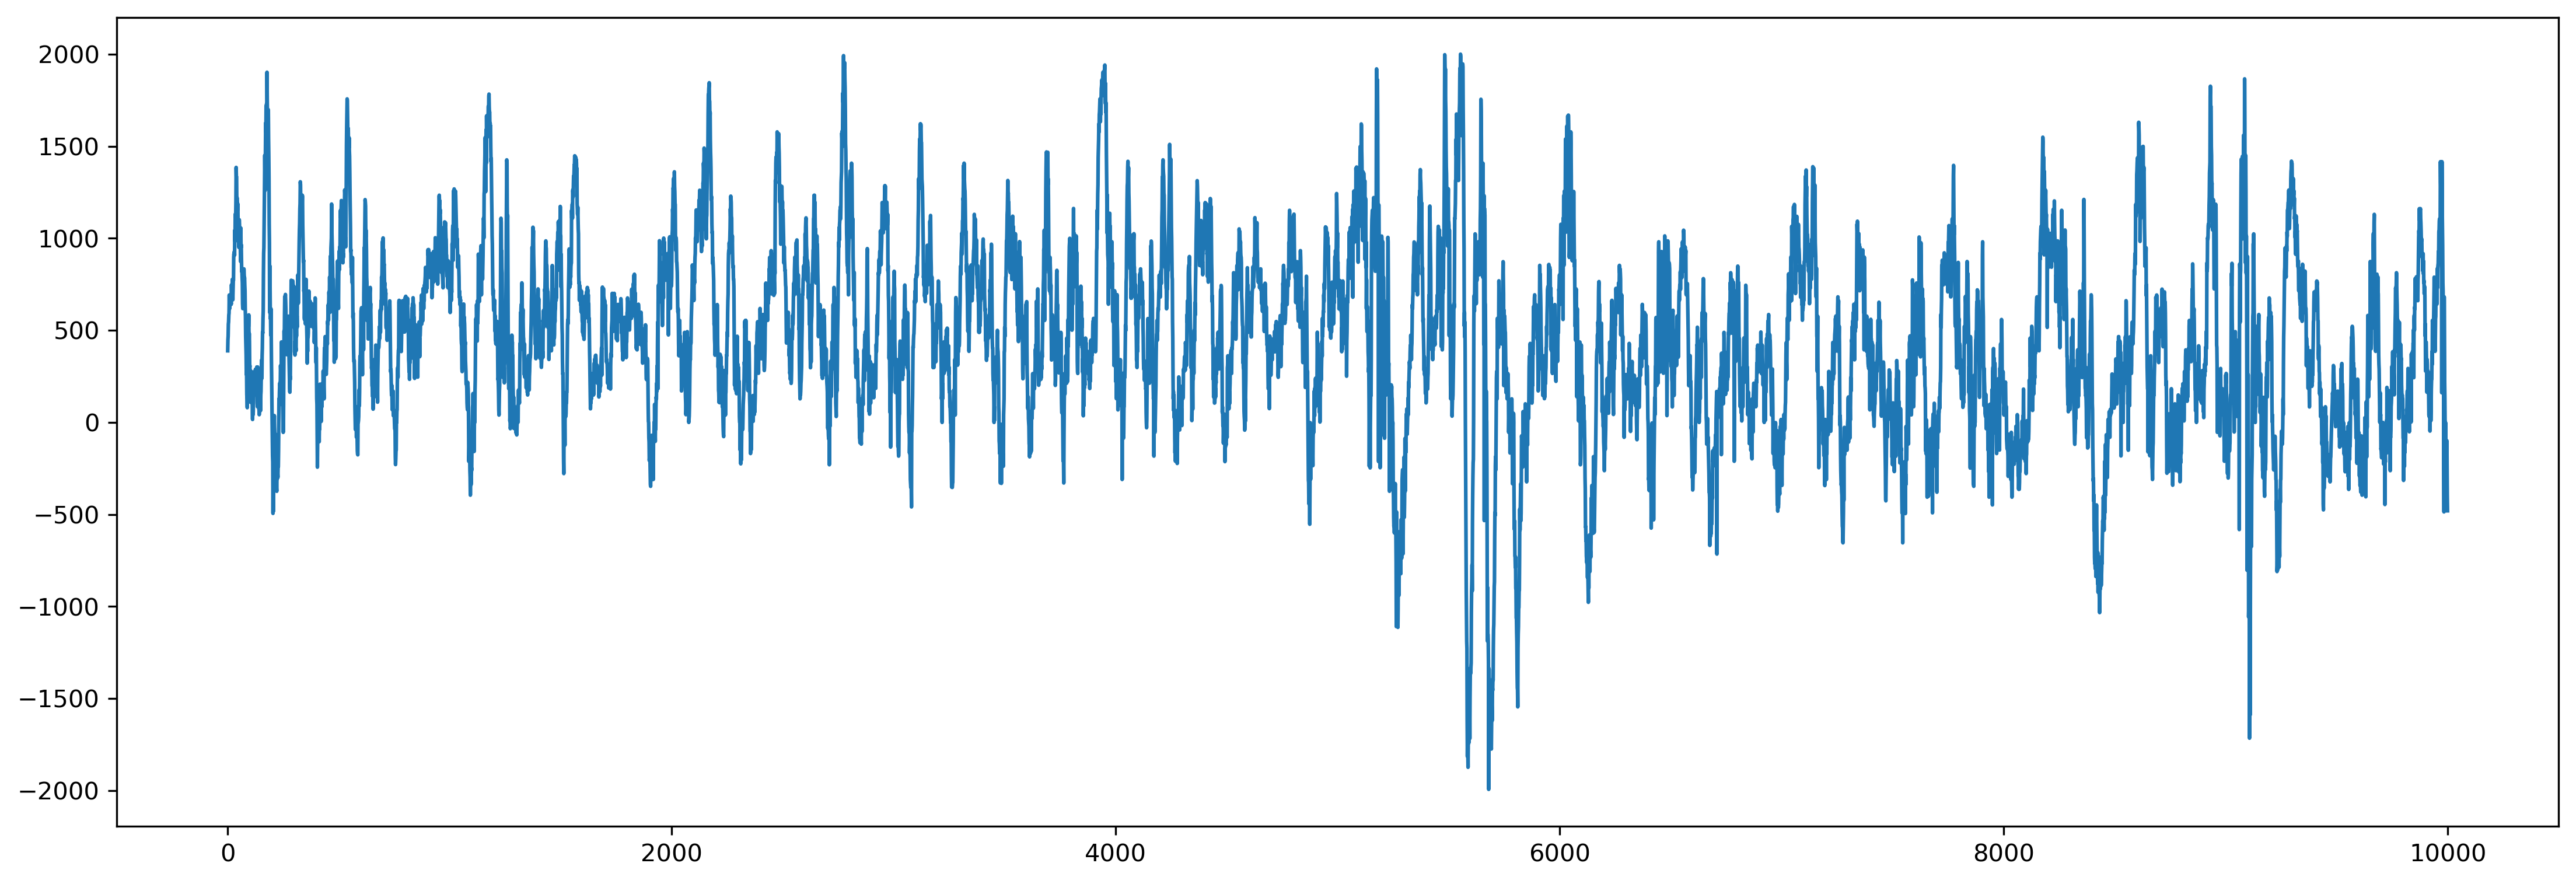

In [10]:
plt.figure(figsize=(18,6),dpi = 300)
x=6007000
plt.plot(lfps[6,x:x+10000])

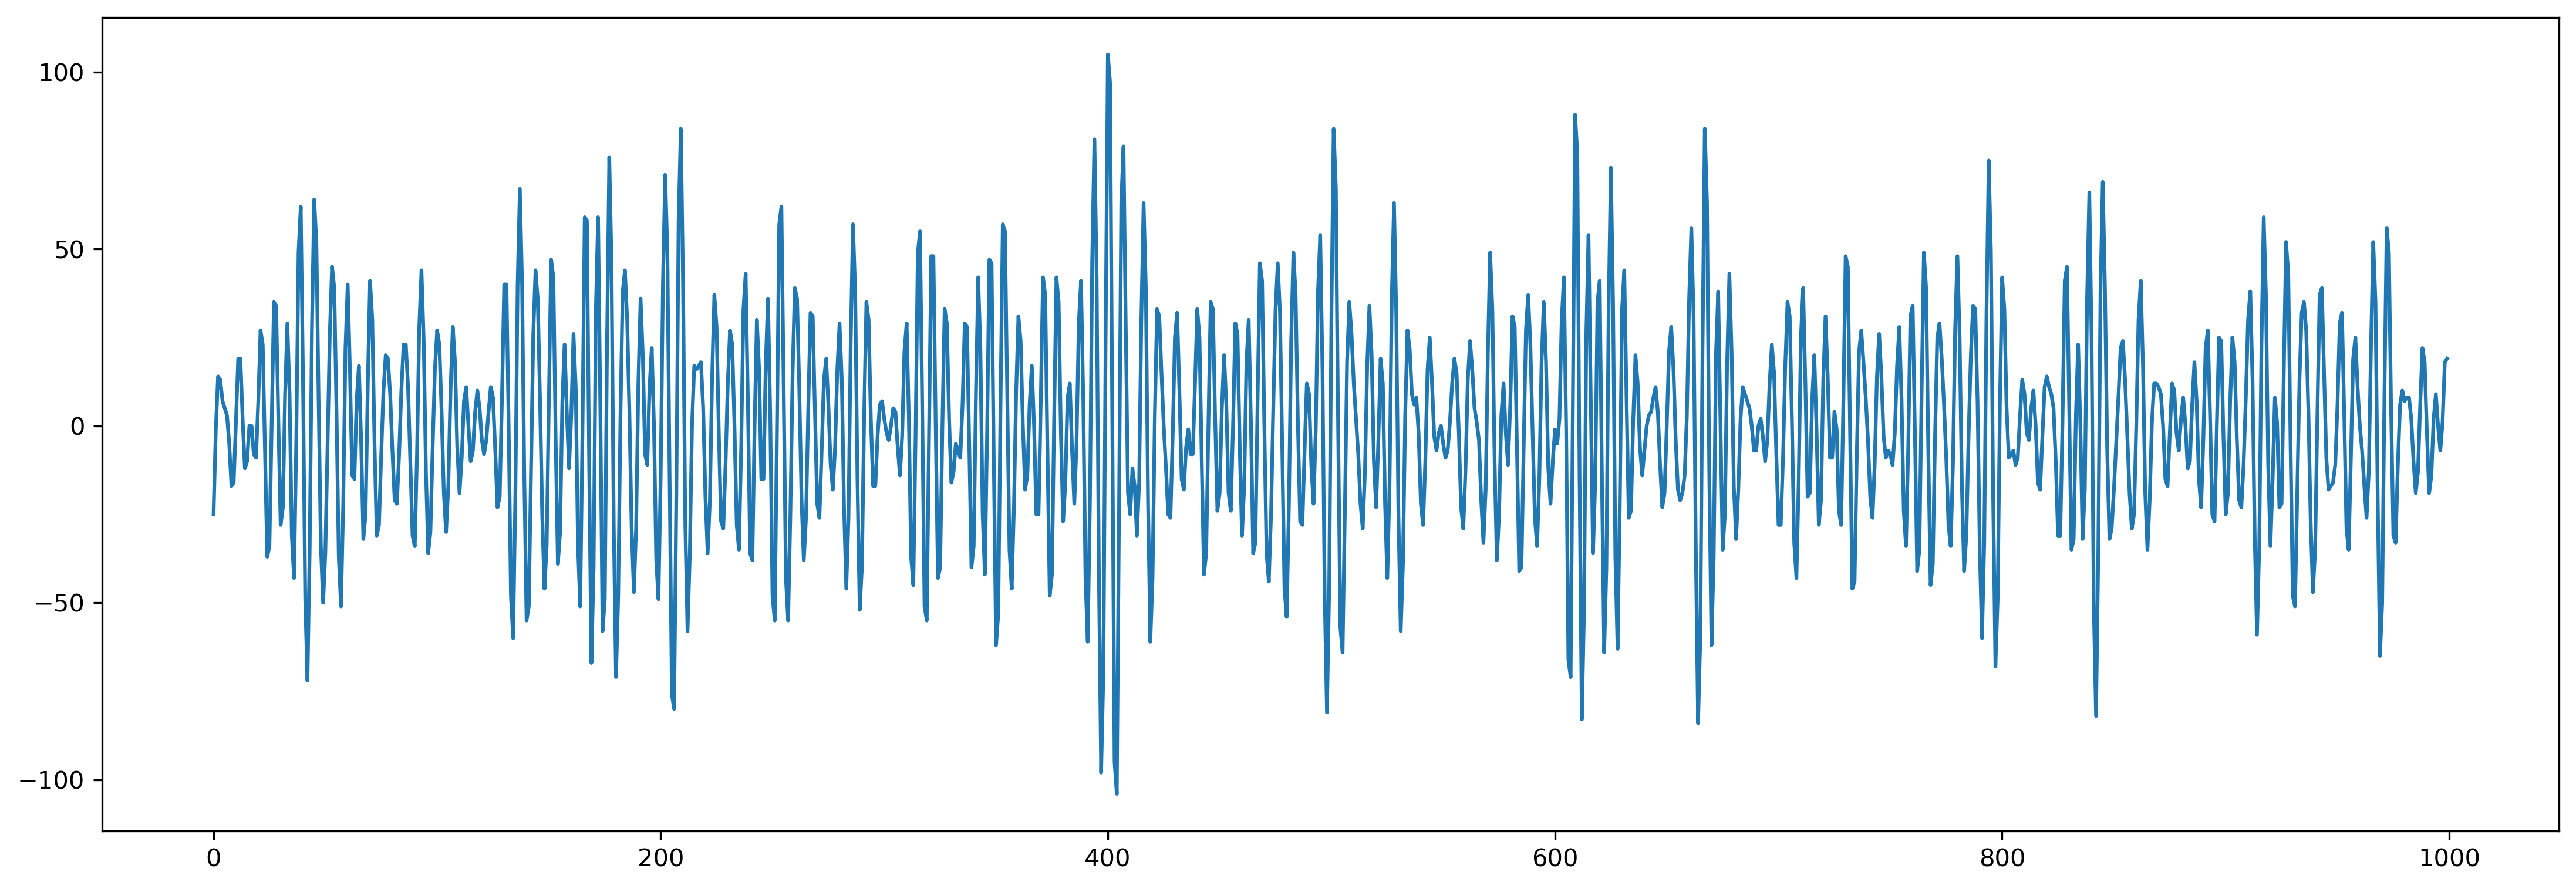

In [11]:
plt.figure(figsize=(18,6),dpi = 300)
x=6007000
plt.plot(filtered_lfps[6,x:x+1000])

In [12]:
Karlsson_ripple_times = Karlsson_ripple_detector(
    np.arange(len(filtered_lfps[0,:])), 
    filtered_lfps[:,:].T, 
   np.squeeze( 3* np.ones( (1, len(filtered_lfps[0,:]))   )) , #speed
    SAMPLING_FREQUENCY
)

In [13]:
display(Karlsson_ripple_times)

,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,
1,0,874,874,0.158999,0.141338,0.745812,-0.541390,3.0,3.0,3.0,3.0,3.0,3.0
2,877,952,75,-0.093506,-0.108906,0.096672,-0.190530,3.0,3.0,3.0,3.0,3.0,3.0
3,961,1093,132,0.017784,0.009613,0.333141,-0.211615,3.0,3.0,3.0,3.0,3.0,3.0
4,1124,1304,180,0.038762,0.032600,0.221259,-0.136176,3.0,3.0,3.0,3.0,3.0,3.0
5,1355,1451,96,-0.018838,-0.046455,0.213202,-0.193279,3.0,3.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27918,9030069,9030280,211,-0.061788,-0.062467,0.096411,-0.179693,3.0,3.0,3.0,3.0,3.0,3.0
27919,9030568,9030604,36,-0.002373,0.003591,0.027783,-0.077884,3.0,3.0,3.0,3.0,3.0,3.0
27920,9030824,9030995,171,-0.058414,-0.056048,0.097506,-0.249308,3.0,3.0,3.0,3.0,3.0,3.0


# END OF TESTED CODE. BELOW IS CODE TO GENERATE DIFFERENT PLOTS

In [ ]:
for i in range(24):
    plt.figure(figsize=(18,6),dpi = 300)
    plt.plot(lfps[i,])
    plt.savefig(str(i)+"new.jpg")

In [18]:
for i in range(24):
    plt.figure(figsize=(18,6),dpi = 300)
    plt.plot(filtered_lfps[i,:])
    plt.savefig(str(i)+"filtered.jpg")
    plt.close()

In [ ]:
for i in range(24):
    plt.figure(figsize=(18,6),dpi = 300)
    plt.plot(lfps[i,3000000:5000000],'*')
    plt.savefig(str(i)+"star.jpg")
    plt.close()

In [10]:
for i in range(24):
    plt.figure(figsize=(18,6),dpi = 300)
    plt.plot(filtered_lfps[i,3000000:5000000])
    plt.savefig(str(i)+"filtered_smallnew.jpg")
    plt.close()

In [ ]:
np.mean(lfps[3,:][lfps[3,:]>0 ]     )

In [ ]:
for i in range(24):
    plt.figure(figsize=(18,6),dpi = 300)
    plt.plot(lfps[i,3000000:5000000])
    plt.savefig(str(i)+"small.jpg")
    plt.close()

In [ ]:

plt.figure(figsize=(18,6),dpi = 100)
for i in range(24):
    plt.plot(lfps[i,:],'*')
plt.show()

In [ ]:
plt.figure(figsize=(18,6))
for i in range(24):
    plt.plot(filtered_lfps[:,i])
plt.show()